In [2]:
#%%  Import all the packages needed to explore grib data
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy

from pathlib  import Path

import sys
# insert path to src folder no matter from where the notebook is run
sys.path.insert(0, "..")

# import my stuff:
from src.plotting.plot_ens import (colors_ens, plot_ens_lineplot,get_country_record,
                                   plot_ens_tripleplot)
from src.data_loading.load_ens import (calculate_wind_speed,
                                       load_ens_data_ED)
                                    
from src.preprocessing.reducers import  average_over_shape 

# auto reload imports
%load_ext autoreload
%autoreload 2
#%% wider plots
# wider plots
plt.rcParams['figure.figsize'] = [10, 5]
from IPython.core.interactiveshell import InteractiveShell
# just the last output
InteractiveShell.ast_node_interactivity = "last_expr"
import warnings
warnings.filterwarnings('ignore')

# =======================================
#%% Flags and directories
## Flags and directories
# =========================================
load_full_D = True
drop_wind_components = True
calculate_diffs = True
save_fig = False

validate_function = False
if validate_function:
    from src.tests.test_functions import validate_function_average_over_shape

dir_data = Path('../data/ecmwf-ens')
fn_E = dir_data /"mars_v05e_2017-01-02_Mon.grib"
fn_D = dir_data /"mars_v05d_2017-01-02_Mon.grib"
fn_D= str(fn_D)
fn_E= str(fn_E)

dir_fig = Path('../report/figures')

latlon_vienna = (48.2082, 16.3738)

In [3]:
#%% Load the data
## Load the data
# =========================================
ds, dsD = load_ens_data_ED(fn_E, fn_D,
                           load_full_D=False,
                           drop_wind_components=True,
                           temperature_in_C=True,
                           calculate_diffs=True
                           )


2023-06-05 11:08:18,207 - INFO- Load - Loading ../data/ecmwf-ens/mars_v05e_2017-01-02_Mon.grib
2023-06-05 11:08:33,762 - INFO- Load - Loading ../data/ecmwf-ens/mars_v05d_2017-01-02_Mon.grib (reduced)
2023-06-05 11:08:55,278 - INFO- Load - Processing fields: wind temperature diffs 
2023-06-05 11:09:02,397 - INFO- Load - Loading complete


In [4]:
#%% print variables
## print variables
# =========================================
#print bold header and title
print("ECMWF ENS Extended data variables :\n")
print(f"{'var':6s} {'units':10s} {'long_name':30s}")
print("-"*50)
for v in ds.data_vars:
    # table format
    print(f"{v:6s} {ds[v].attrs['units']:10s} {ds[v].attrs['long_name']:30s}")
    
vars = ["t2m","d2m","stl4","ssrd","strd","w10","w100"]

ECMWF ENS Extended data variables :

var    units      long_name                     
--------------------------------------------------
sp     Pa         Surface pressure              
t2m    C          2 metre temperature           
ssrd   J m**-2/h  Δ Surface short-wave (solar) radiation downwards
strd   J m**-2/h  Δ Surface long-wave (thermal) radiation downwards
ssr    J m**-2/h  Δ Surface net short-wave (solar) radiation
ro     m          Runoff                        
stl4   C          Soil temperature level 4      
d2m    C          2 metre dewpoint temperature  
w10    m s**-1    10m wind speed                
w100   m s**-1    100m wind speed               


In [ ]:
from src.preprocessing.reducers import calculate_variance


In [5]:
dsD.latitude

<xarray.DataArray 'latitude' (latitude: 131)>
array([72. , 71.7, 71.4, 71.1, 70.8, 70.5, 70.2, 69.9, 69.6, 69.3, 69. , 68.7,
       68.4, 68.1, 67.8, 67.5, 67.2, 66.9, 66.6, 66.3, 66. , 65.7, 65.4, 65.1,
       64.8, 64.5, 64.2, 63.9, 63.6, 63.3, 63. , 62.7, 62.4, 62.1, 61.8, 61.5,
       61.2, 60.9, 60.6, 60.3, 60. , 59.7, 59.4, 59.1, 58.8, 58.5, 58.2, 57.9,
       57.6, 57.3, 57. , 56.7, 56.4, 56.1, 55.8, 55.5, 55.2, 54.9, 54.6, 54.3,
       54. , 53.7, 53.4, 53.1, 52.8, 52.5, 52.2, 51.9, 51.6, 51.3, 51. , 50.7,
       50.4, 50.1, 49.8, 49.5, 49.2, 48.9, 48.6, 48.3, 48. , 47.7, 47.4, 47.1,
       46.8, 46.5, 46.2, 45.9, 45.6, 45.3, 45. , 44.7, 44.4, 44.1, 43.8, 43.5,
       43.2, 42.9, 42.6, 42.3, 42. , 41.7, 41.4, 41.1, 40.8, 40.5, 40.2, 39.9,
       39.6, 39.3, 39. , 38.7, 38.4, 38.1, 37.8, 37.5, 37.2, 36.9, 36.6, 36.3,
       36. , 35.7, 35.4, 35.1, 34.8, 34.5, 34.2, 33.9, 33.6, 33.3, 33. ])
Coordinates:
    time                 datetime64[ns] 2017-01-02
    surface              float64 0.0
  * latitude             (latitude) float64 72.0 71.7 71.4 ... 33.6 33.3 33.0
    depthBelowLandLayer  float64 100.0
Attributes:
    units:             degrees_north
    standard_name:     latitude
    long_name:         latitude
    stored_direction:  decreasing

In [6]:
np.cos(np.deg2rad(ds.latitude))

<xarray.DataArray 'latitude' (latitude: 131)>
array([0.30901699, 0.31399246, 0.31895931, 0.32391742, 0.32886665,
       0.33380686, 0.33873792, 0.34365969, 0.34857205, 0.35347484,
       0.35836795, 0.36325123, 0.36812455, 0.37298778, 0.37784079,
       0.38268343, 0.38751559, 0.39233712, 0.39714789, 0.40194778,
       0.40673664, 0.41151436, 0.41628079, 0.42103581, 0.42577929,
       0.4305111 , 0.4352311 , 0.43993917, 0.44463518, 0.449319  ,
       0.4539905 , 0.45864955, 0.46329604, 0.46792981, 0.47255076,
       0.47715876, 0.48175367, 0.48633538, 0.49090375, 0.49545867,
       0.5       , 0.50452762, 0.50904142, 0.51354125, 0.51802701,
       0.52249856, 0.5269558 , 0.53139858, 0.53582679, 0.54024032,
       0.54463904, 0.54902282, 0.55339155, 0.55774511, 0.56208338,
       0.56640624, 0.57071357, 0.57500525, 0.57928117, 0.58354121,
       0.58778525, 0.59201318, 0.59622487, 0.60042023, 0.60459911,
       0.60876143, 0.61290705, 0.61703588, 0.62114778, 0.62524266,
       0.62932039, 0.63338087, 0.63742399, 0.64144963, 0.64545769,
       0.64944805, 0.6534206 , 0.65737525, 0.66131187, 0.66523035,
       0.66913061, 0.67301251, 0.67687597, 0.68072087, 0.68454711,
       0.68835458, 0.69214317, 0.6959128 , 0.69966334, 0.7033947 ,
       0.70710678, 0.71079947, 0.71447268, 0.7181263 , 0.72176023,
       0.72537437, 0.72896863, 0.7325429 , 0.73609709, 0.73963109,
       0.74314483, 0.74663818, 0.75011107, 0.75356339, 0.75699506,
       0.76040597, 0.76379603, 0.76716515, 0.77051324, 0.77384021,
       0.77714596, 0.78043041, 0.78369346, 0.78693502, 0.79015501,
       0.79335334, 0.79652992, 0.79968466, 0.80281748, 0.80592828,
       0.80901699, 0.81208353, 0.8151278 , 0.81814972, 0.82114921,
       0.82412619, 0.82708057, 0.83001229, 0.83292124, 0.83580736,
       0.83867057])
Coordinates:
    time                 datetime64[ns] 2017-01-02
    surface              float64 0.0
  * latitude             (latitude) float64 72.0 71.7 71.4 ... 33.6 33.3 33.0
    depthBelowLandLayer  float64 100.0
Attributes:
    units:             degrees_north
    standard_name:     latitude
    long_name:         latitude
    stored_direction:  decreasing

In [9]:
ds.weighted(np.cos(np.deg2rad(ds.latitude)))

DatasetWeighted with weights along dimensions: latitude

In [10]:
ds.drop_vars(["d2m"])

<xarray.Dataset>
Dimensions:              (number: 5, step: 269, latitude: 131, longitude: 157)
Coordinates:
  * number               (number) int64 1 2 3 4 5
    time                 datetime64[ns] 2017-01-02
  * step                 (step) timedelta64[ns] 00:00:00 ... 46 days 00:00:00
    surface              float64 0.0
  * latitude             (latitude) float64 72.0 71.7 71.4 ... 33.6 33.3 33.0
  * longitude            (longitude) float64 -12.0 -11.7 -11.4 ... 34.5 34.8
    valid_time           (step) datetime64[ns] 2017-01-02 ... 2017-02-17
    depthBelowLandLayer  float64 100.0
Data variables:
    sp                   (number, step, latitude, longitude) float32 1.019e+0...
    t2m                  (number, step, latitude, longitude) float32 -6.183 ....
    ssrd                 (number, step, latitude, longitude) float64 0.0 ... 0.0
    strd                 (number, step, latitude, longitude) float64 0.0 ... ...
    ssr                  (number, step, latitude, longitude) float64 0.0 ... 0.0
    ro                   (number, step, latitude, longitude) float32 0.0 ... ...
    stl4                 (number, step, latitude, longitude) float32 1.085 .....
    w10                  (number, step, latitude, longitude) float32 2.888 .....
    w100                 (number, step, latitude, longitude) float32 2.894 .....
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-06-05T11:08 GRIB to CDM+CF via cfgrib-0.9.1...

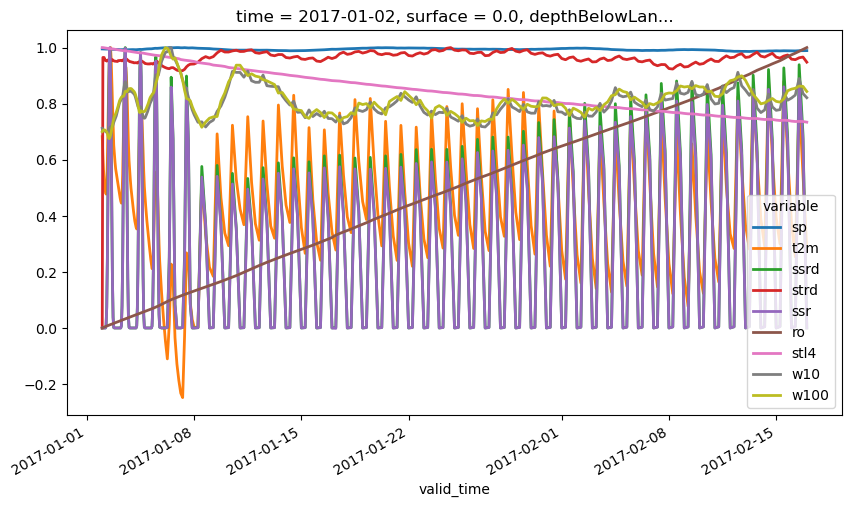

In [11]:
ds_plot=ds.weighted(np.cos(np.deg2rad(ds.latitude))).mean(["latitude","longitude","number"]).drop_vars(["d2m"]).to_array(dim="variable")
ds_plot=ds_plot/ds_plot.max(dim=["step"])
ds_plot.plot.line(x="valid_time", hue="variable", lw=2)

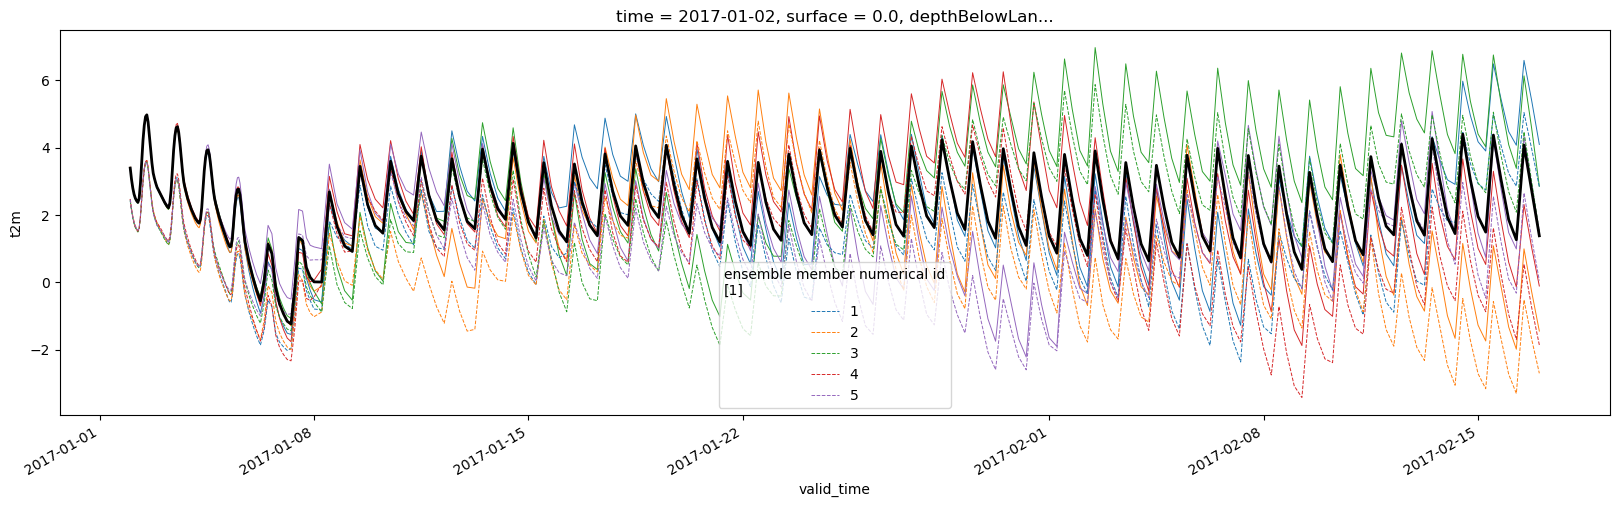

In [12]:
fig, ax = plt.subplots(figsize=(20,5))
ds.weighted(np.cos(np.deg2rad(ds.latitude))).mean(["latitude","longitude"])["t2m"].plot.line(x="valid_time", hue="number",ax=ax,lw=0.7)
#reset color cycle
plt.gca().set_prop_cycle(None)
ds.mean(["latitude","longitude"])["t2m"].plot.line(x="valid_time", hue="number", ls="--",ax=ax,lw=0.7)

ds.weighted(np.cos(np.deg2rad(ds.latitude))).mean(["latitude","longitude","number"])["t2m"].plot(x="valid_time",c="k",lw=2)

In [13]:
from src.preprocessing.reducers import calculate_climatological_spatial_mean

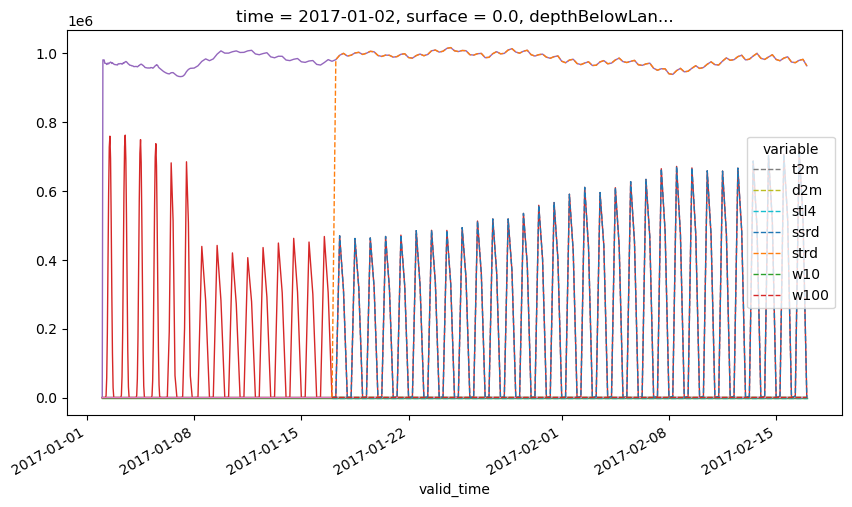

In [14]:
calculate_climatological_spatial_mean(ds).to_array(dim="variable").plot.line(x="valid_time", hue="variable", lw=1)
calculate_climatological_spatial_mean(dsD).to_array(dim="variable").plot.line(x="valid_time", hue="variable", lw=1,ls="--")

In [16]:
ds.weighted(np.cos(np.deg2rad(ds.latitude))).mean(["latitude","longitude","number"]).mean(["step"]).t2m.values

array(2.29968597)

In [22]:
ds.step

<xarray.DataArray 'step' (step: 269)>
array([               0,    3600000000000,    7200000000000, ...,
       3931200000000000, 3952800000000000, 3974400000000000],
      dtype='timedelta64[ns]')
Coordinates:
    time                 datetime64[ns] 2017-01-02
  * step                 (step) timedelta64[ns] 00:00:00 ... 46 days 00:00:00
    surface              float64 0.0
    valid_time           (step) datetime64[ns] 2017-01-02 ... 2017-02-17
    depthBelowLandLayer  float64 100.0
Attributes:
    long_name:      time since forecast_reference_time
    standard_name:  forecast_period

In [60]:
ds.step.diff("step").rename("diff_step")
# ds.step.diff("step").diff("step").isel(step=ds.step.diff("step").diff("step").argsort().isel(step=slice(0,4)))

<xarray.DataArray 'diff_step' (step: 268)>
array([ 3600000000000,  3600000000000,  3600000000000,  3600000000000,
        3600000000000,  3600000000000,  3600000000000,  3600000000000,
        3600000000000,  3600000000000,  3600000000000,  3600000000000,
        3600000000000,  3600000000000,  3600000000000,  3600000000000,
        3600000000000,  3600000000000,  3600000000000,  3600000000000,
        3600000000000,  3600000000000,  3600000000000,  3600000000000,
        3600000000000,  3600000000000,  3600000000000,  3600000000000,
        3600000000000,  3600000000000,  3600000000000,  3600000000000,
        3600000000000,  3600000000000,  3600000000000,  3600000000000,
        3600000000000,  3600000000000,  3600000000000,  3600000000000,
        3600000000000,  3600000000000,  3600000000000,  3600000000000,
        3600000000000,  3600000000000,  3600000000000,  3600000000000,
        3600000000000,  3600000000000,  3600000000000,  3600000000000,
        3600000000000,  3600000000000,  3600000000000,  3600000000000,
        3600000000000,  3600000000000,  3600000000000,  3600000000000,
        3600000000000,  3600000000000,  3600000000000,  3600000000000,
        3600000000000,  3600000000000,  3600000000000,  3600000000000,
        3600000000000,  3600000000000,  3600000000000,  3600000000000,
        3600000000000,  3600000000000,  3600000000000,  3600000000000,
        3600000000000,  3600000000000,  3600000000000,  3600000000000,
...
       21600000000000, 21600000000000, 21600000000000, 21600000000000,
       21600000000000, 21600000000000, 21600000000000, 21600000000000,
       21600000000000, 21600000000000, 21600000000000, 21600000000000,
       21600000000000, 21600000000000, 21600000000000, 21600000000000,
       21600000000000, 21600000000000, 21600000000000, 21600000000000,
       21600000000000, 21600000000000, 21600000000000, 21600000000000,
       21600000000000, 21600000000000, 21600000000000, 21600000000000,
       21600000000000, 21600000000000, 21600000000000, 21600000000000,
       21600000000000, 21600000000000, 21600000000000, 21600000000000,
       21600000000000, 21600000000000, 21600000000000, 21600000000000,
       21600000000000, 21600000000000, 21600000000000, 21600000000000,
       21600000000000, 21600000000000, 21600000000000, 21600000000000,
       21600000000000, 21600000000000, 21600000000000, 21600000000000,
       21600000000000, 21600000000000, 21600000000000, 21600000000000,
       21600000000000, 21600000000000, 21600000000000, 21600000000000,
       21600000000000, 21600000000000, 21600000000000, 21600000000000,
       21600000000000, 21600000000000, 21600000000000, 21600000000000,
       21600000000000, 21600000000000, 21600000000000, 21600000000000,
       21600000000000, 21600000000000, 21600000000000, 21600000000000],
      dtype='timedelta64[ns]')
Coordinates:
    time                 datetime64[ns] 2017-01-02
  * step                 (step) timedelta64[ns] 01:00:00 ... 46 days 00:00:00
    surface              float64 0.0
    valid_time           (step) datetime64[ns] 2017-01-02T01:00:00 ... 2017-0...
    depthBelowLandLayer  float64 100.0

In [ ]:
ds.weighted(np.cos(np.deg2rad(ds.latitude))).mean(["latitude","longitude","number"]).mean(["step"]).t2m.values